#### imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from warnings import filterwarnings
filterwarnings('ignore')

encoder = LabelEncoder()

In [2]:
energy_dataset = pd.read_csv("data/hourly_energy/energy_dataset.csv")
weather_features = pd.read_csv("data/hourly_energy/weather_features.csv")

In [3]:
# weather_features['weather_main'] = weather_features['weather_main'].astype('category')

In [4]:
# pd.to_datetime(energy_dataset.time,utc=True).dt.hour.value_counts()
# pd.to_datetime(weather_features.dt_iso,utc=True).dt.hour.value_counts()

In [5]:
print("weather-",weather_features.shape,"\tenergy-",energy_dataset.shape)

weather- (178396, 17) 	energy- (35064, 29)


weather data and energy data shape don't match but time range does, why?  
boxplot shows outliers for wind_speed, pressure columns in weather dataset.

In [6]:
# without scaling model did not perform so well, try scaling the features
def scale_features(df, name_of_features=[], type_of_features_to_scale='float', scaler=MinMaxScaler(), fit=True):
    scaler_map = {}
    if (len(name_of_features)==0) and type(name_of_features)==list:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[1]==type_of_features_to_scale:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    else:
        for col_no, pair in enumerate(df.dtypes.items()):
            if pair[0] in name_of_features:
                # scaler expects df, so do iloc this way, else it will give a series
                if fit:
                    df.iloc[:,col_no:col_no+1] = scaler.fit_transform(df.iloc[:,col_no:col_no+1])
                else:
                    df.iloc[:,col_no:col_no+1] = scaler.transform(df.iloc[:,col_no:col_no+1])
                # scaler_map[pair[0]] = scaler
    return (df, scaler_map)

def convert_long_to_wide(df):
    final_df = pd.DataFrame()
    unique_cities = df.city_name.unique()
    for city in unique_cities:
        temp_df = df.loc[df['city_name']==city]
        temp_df = temp_df.drop_duplicates(subset=['city_name','dt_iso'],keep='first')
        temp_df = temp_df.reset_index(drop=True)
        # rename columns with the city's name as prefix, remove city name column
        # dt_iso column can be used to merge with the energy dataset so keep it, but rename it to time
        temp_df = temp_df.rename(columns={'dt_iso':'time'}).drop('city_name', axis=1)
        temp_df.columns = [city+'_'+i if i!='time' else i for i in temp_df.columns]

        if final_df.empty:
            final_df = temp_df
        else:
            final_df = pd.merge(final_df, temp_df, on='time')
    return final_df


#### clean up energy dataset

In [7]:
# energy_dataset.describe()

In [8]:
bucket_size_hr = 6
# hr_bins = pd.IntervalIndex.from_tuples([(i,i+bucket_size_hr) for i in range(0,int(24), bucket_size_hr)])
hr_bins = [i for i in range(0,24 + bucket_size_hr, bucket_size_hr)]

In [9]:
# energy_dataset.isna().sum()
energy_dataset['time'] = energy_dataset.time.map(lambda x: x.split("+")[0])
energy_dataset['time'] = pd.to_datetime(energy_dataset['time'],utc=True)
energy_dataset.drop(columns=[
    'generation hydro pumped storage aggregated','forecast wind offshore eday ahead', # nan columns
    # delete columns with only 0 values
    'generation fossil coal-derived gas','generation fossil oil shale','generation fossil peat','generation geothermal',
    'generation marine','generation wind offshore'
], inplace=True)
energy_dataset.dropna(inplace=True)

# to inverse transform while calc error
# target_col_scaler = StandardScaler()
target_col_scaler = MinMaxScaler()
target_col_scaler.fit(energy_dataset['price actual'].values.reshape(-1,1))

energy_dataset, energy_scaler_map = scale_features(energy_dataset, type_of_features_to_scale='float')

energy_dataset['dow'] = energy_dataset['time'].dt.day_of_week
energy_dataset['hod'] = energy_dataset['time'].dt.hour
energy_dataset['moy'] = energy_dataset['time'].dt.month
energy_dataset['hour_bucket'] = pd.cut(energy_dataset['hod'], bins=hr_bins, include_lowest=True, labels=False, retbins=False)


ts_features = ['dow','hod','moy']

<Axes: >

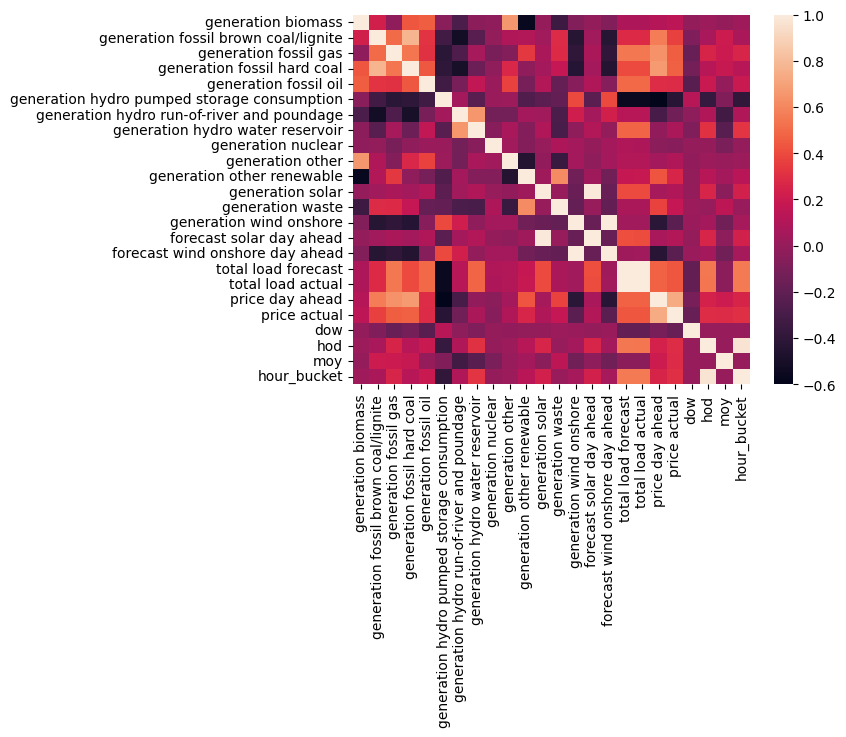

In [10]:
sns.heatmap(energy_dataset.iloc[:,1:].corr())

#### clean up weather dataset

[]

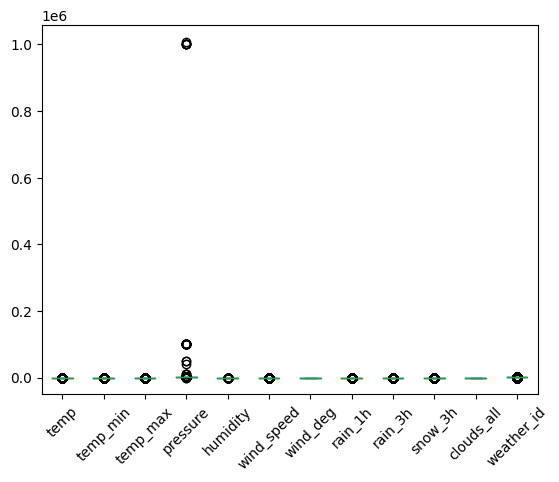

In [11]:
# observed the range of time in both datasets match, and also the shape mismtaches, but is close to about 5 times.
# the weather dataset is given for the same time for 5 different cities, no clue why, but let's see if these improve model as features
weather_features = weather_features.drop_duplicates(subset=['dt_iso','city_name'],keep='first')
weather_features.plot(kind='box')
plt.xticks(rotation=45)
plt.plot()

In [12]:
#TODO make 6 hour bucket feature  [DONE]
# remove outliers from data  [DONE]
# plot temp in each city, should be similar to each other, if yes then drop except one [not scale it on the same spectrum]


In [13]:
# handle outliers
weather_features.loc[(weather_features['pressure'] > (weather_features['pressure'] + (2 * weather_features['pressure'].mean())))
                    |  (weather_features['pressure'] < ( weather_features['pressure'] - (2 * weather_features['pressure'].mean()))) , 'pressure'] = np.nan
weather_features.loc[(weather_features['wind_speed'] > (weather_features['wind_speed'] + (2 * weather_features['wind_speed'].mean())))
                    |  (weather_features['wind_speed'] < (weather_features['wind_speed'] - (2 * weather_features['wind_speed'].mean()))) , 'wind_speed'] = np.nan

# both feature seem to be something that is okay to fill with mean, wind and pressure
weather_features['pressure'] = weather_features['pressure'].fillna(weather_features['pressure'].mean())
weather_features['wind_speed'] = weather_features['wind_speed'].fillna(weather_features['wind_speed'].mean())

In [14]:
scaler = MinMaxScaler()
scaler.fit(weather_features[[i for i in weather_features.columns if 'temp' in i]].values.flatten().reshape(-1,1))
weather_features, temp_scalers = scale_features(df=weather_features, name_of_features=[i for i in weather_features.columns if 'temp' in i], scaler=scaler, fit=False)
weather_features[[i for i in weather_features.columns if 'temp' not in i]], weather_features_scaler = scale_features(df=weather_features[[i for i in weather_features.columns if 'temp' not in i]])

weather_features

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,0.139790,0.139790,0.139790,0.000993,77,0.007519,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,0.139790,0.139790,0.139790,0.000993,77,0.007519,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,0.433203,0.422848,0.439823,0.001019,54,0.022556,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,0.399253,0.388898,0.405873,0.001020,62,0.022556,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,0.388898,0.388898,0.388898,0.001019,58,0.030075,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,0.371923,0.371923,0.371923,0.001020,57,0.030075,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [15]:
# some columns are largely the same value while we have seen , keep note of values, wind_speed and pressure have outlier, so were showing two extreme
# weather_features.hist(bins=100)
# plt.plot()

In [16]:
weather_features

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,0.139790,0.139790,0.139790,0.000993,77,0.007519,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,0.139790,0.139790,0.139790,0.000993,77,0.007519,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,0.126396,0.126396,0.126396,0.000994,78,0.000000,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178391,2018-12-31 19:00:00+01:00,Seville,0.433203,0.422848,0.439823,0.001019,54,0.022556,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178392,2018-12-31 20:00:00+01:00,Seville,0.399253,0.388898,0.405873,0.001020,62,0.022556,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178393,2018-12-31 21:00:00+01:00,Seville,0.388898,0.388898,0.388898,0.001019,58,0.030075,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n
178394,2018-12-31 22:00:00+01:00,Seville,0.371923,0.371923,0.371923,0.001020,57,0.030075,60,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [17]:
# simply concating will repeat the columns names
# weather_features_wide = pd.concat([weather_features.loc[i].reset_index() for i in weather_features.groupby('city_name').groups.values()], axis=1)

weather_features['weather_main'] = encoder.fit_transform(weather_features['weather_main'])
weather_features['weather_description'] = encoder.fit_transform(weather_features['weather_description'])
weather_features['weather_icon'] = encoder.fit_transform(weather_features['weather_icon'])

columns_to_drop = ['rain_3h','weather_id','snow_3h']

weather_features = weather_features.drop(columns=columns_to_drop)

weather_features_wide = convert_long_to_wide(weather_features)
# removing scientific notations of numbers from data

weather_features_wide.describe()

,Valencia_temp,Valencia_temp_min,Valencia_temp_max,Valencia_pressure,Valencia_humidity,Valencia_wind_speed,Valencia_wind_deg,Valencia_rain_1h,Valencia_clouds_all,Valencia_weather_main,...,Seville_temp_max,Seville_pressure,Seville_humidity,Seville_wind_speed,Seville_wind_deg,Seville_rain_1h,Seville_clouds_all,Seville_weather_main,Seville_weather_description,Seville_weather_icon
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,...,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,0.484535,0.475058,0.494278,0.001008,65.093971,0.020244,160.801648,0.002872,20.740475,0.930755,...,0.573107,0.001010,63.780516,0.018667,151.885809,0.003428,14.165070,0.928188,24.647045,4.564368
std,0.122807,0.120362,0.127711,0.000012,19.678281,0.019421,120.412607,0.021966,25.604016,1.669066,...,0.154182,0.000007,22.881475,0.014049,104.328755,0.017946,26.169696,2.006614,11.000688,5.767369
min,0.111877,0.111877,0.111877,0.000961,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166746,0.000978,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.388898,0.388898,0.397386,0.001004,51.000000,0.007519,50.000000,0.000000,0.000000,0.000000,...,0.456799,0.001006,46.000000,0.007519,50.000000,0.000000,0.000000,0.000000,20.000000,1.000000
50%,0.474453,0.473774,0.490749,0.001009,67.000000,0.015038,130.000000,0.000000,20.000000,1.000000,...,0.558649,0.001010,67.000000,0.015038,175.000000,0.000000,0.000000,0.000000,31.000000,2.000000
75%,0.575624,0.562383,0.592599,0.001013,82.000000,0.030075,280.000000,0.000000,20.000000,1.000000,...,0.694449,0.001015,83.000000,0.022556,230.000000,0.000000,20.000000,1.000000,31.000000,5.000000
max,0.830250,0.830250,0.892548,0.001078,100.000000,1.000000,360.000000,1.000000,100.000000,11.000000,...,1.000000,0.001081,100.000000,0.112782,360.000000,0.250000,100.000000,11.000000,39.000000,23.000000


In [18]:
# weather_features_wide[[i for i in weather_features_wide.columns if 'temp' in i]].hist(sharex=True,sharey=True)
# plt.tight_layout(w_pad=5)
# plt.plot()

#### models

In [19]:
feature_list = [i for i in energy_dataset.columns[1:] if 'generation' in i]
feature_list.extend(ts_features)
# comment below line if not to use the weather features
feature_list.extend([i for i in weather_features_wide.columns if i!='time'])

target_col = 'price actual'

In [20]:
# convert ts to int for easier handling
energy_dataset['ts_int'] = pd.to_datetime(energy_dataset['time'],utc=True).astype(int)/ 10**9
weather_features_wide['ts_int'] = pd.to_datetime(weather_features_wide['time'],utc=True).astype(int)/ 10**9

final_dataset = pd.merge(energy_dataset.drop('time',axis=1), weather_features_wide.drop('time',axis=1), on='ts_int')
# final_dataset = energy_dataset.copy(deep=True)

In [21]:
# pca also is not making model better, try involving past history of price
def add_lag_price_feature(df, timestep):
    timestep_features = []
    for i in range(1,timestep+1):
        df[f'{i}_lag_price'] = df[target_col].shift(i)
        timestep_features.append(f'{i}_lag_price')
    return df, timestep_features

n=30
final_dataset, lag_price_features = add_lag_price_feature(final_dataset, n)
feature_list.extend(lag_price_features)
final_dataset = final_dataset.iloc[n:,:]

In [22]:
pca = PCA(n_components=0.8)
pca.fit(final_dataset[feature_list])

# num_components = len(pca.explained_variance_ratio_)
# plt.figure(figsize=(10, 6))
# plt.bar(np.arange(num_components), pca.explained_variance_ratio_)
# plt.plot(np.cumsum(pca.explained_variance_ratio_))
# plt.xlabel('Principal component')
# plt.ylabel('Explained variance')
# plt.show()

PCA(n_components=0.8)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
model = RandomForestRegressor(n_estimators=100,# max_depth=int(0.7*(len(feature_list))), 
                              random_state=42, min_weight_fraction_leaf=0.005, 
                            #   min_samples_leaf=5, #min_samples_split=40
                            )

x_train, x_test, y_train, y_test = train_test_split(final_dataset[feature_list], final_dataset[target_col], test_size = 0.1, shuffle=False)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)

# train_set, test_set = [x_train,y_train], [x_train,y_train]
train_set, test_set = [x_train,y_train], [x_test,y_test]

test_set[1] = target_col_scaler.inverse_transform(test_set[1].values.reshape(-1,1))

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

predictions = target_col_scaler.inverse_transform(predictions.reshape(-1,1))

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 14.035898496868768
RMSE 15.988578295376819


"best accuracy until now is MAE : 10, RMSE: 12.5"

In [24]:
raise NotImplementedError("want to stop execution here if run all is done")

NotImplementedError: want to stop execution here if run all is done

<Axes: >

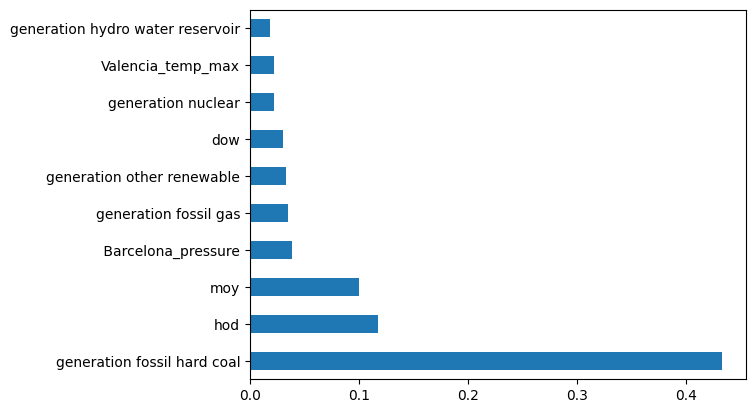

In [41]:
pd.Series(model.feature_importances_,feature_list).nlargest(10).plot(kind='barh')

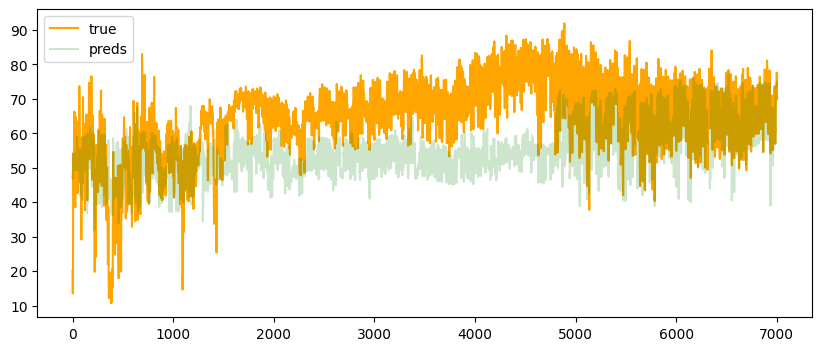

In [22]:
# visualizing the predictions/ residuals
plt.figure(figsize=(10,4))
plt.plot(test_set[1].reset_index(drop=True),c='orange', alpha=1)
plt.plot(predictions,'green', alpha=0.2)
plt.legend(['true','preds'])
plt.show()

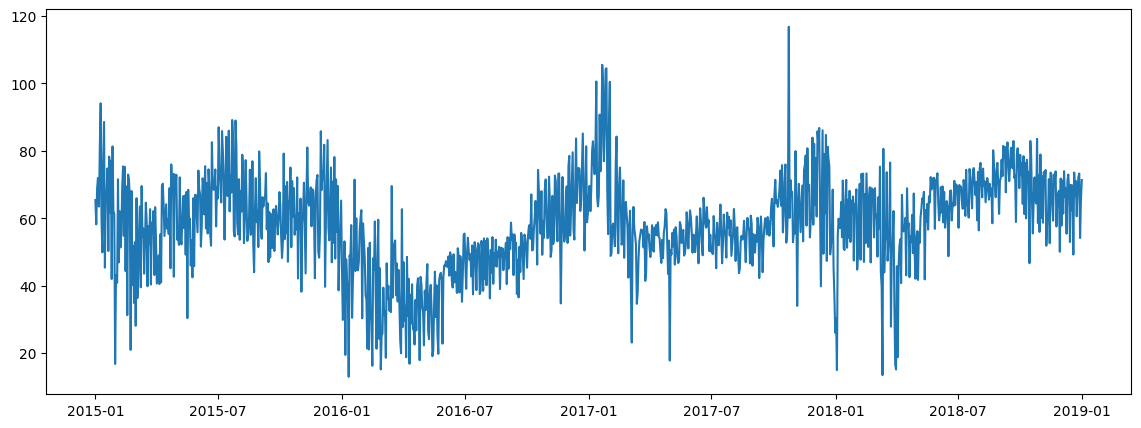

In [23]:
plt.figure(figsize=(14,5))
plt.plot(energy_dataset.set_index('time')[target_col].iloc[range(0,len(energy_dataset), 30)])

In [43]:
import xgboost as xg

# Train and test set are converted to DMatrix objects, 
# as it is required by learning API. 
train_dmatrix = xg.DMatrix(data = train_set[0], label = train_set[1]) 
test_dmatrix = xg.DMatrix(data = test_set[0], label = test_set[1]) 


param = {"booster":"gblinear", "objective":"reg:linear"} 
  
xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10,)
predictions = xgb_r.predict(test_dmatrix) 

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 11.432361748726418
RMSE 13.45937237867996


In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(train_set[0], train_set[1])
predictions = model.predict(test_set[0])

print("MAE",mean_absolute_error(test_set[1], predictions))
print("RMSE",root_mean_squared_error(test_set[1], predictions))

MAE 11.432771734501387
RMSE 13.460157934290535
